<a href="https://colab.research.google.com/github/thierrydecae/NLP-classification-using-BERT/blob/main/NLP_Classification_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports and Setup

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

In [ ]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 34.1 MB/s eta 0:00:00


In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

#### Import & Process Data

In [ ]:
def twenty_newsgroup_to_df(subset):
    newsgroups = fetch_20newsgroups(subset=subset, remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups.data, newsgroups.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame(newsgroups.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    return out

train=twenty_newsgroup_to_df('train')
test=twenty_newsgroup_to_df('test')

<ipython-input-4-8b138d5adad3>:11: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  out['date'] = pd.to_datetime('now')
<ipython-input-4-8b138d5adad3>:11: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  out['date'] = pd.to_datetime('now')


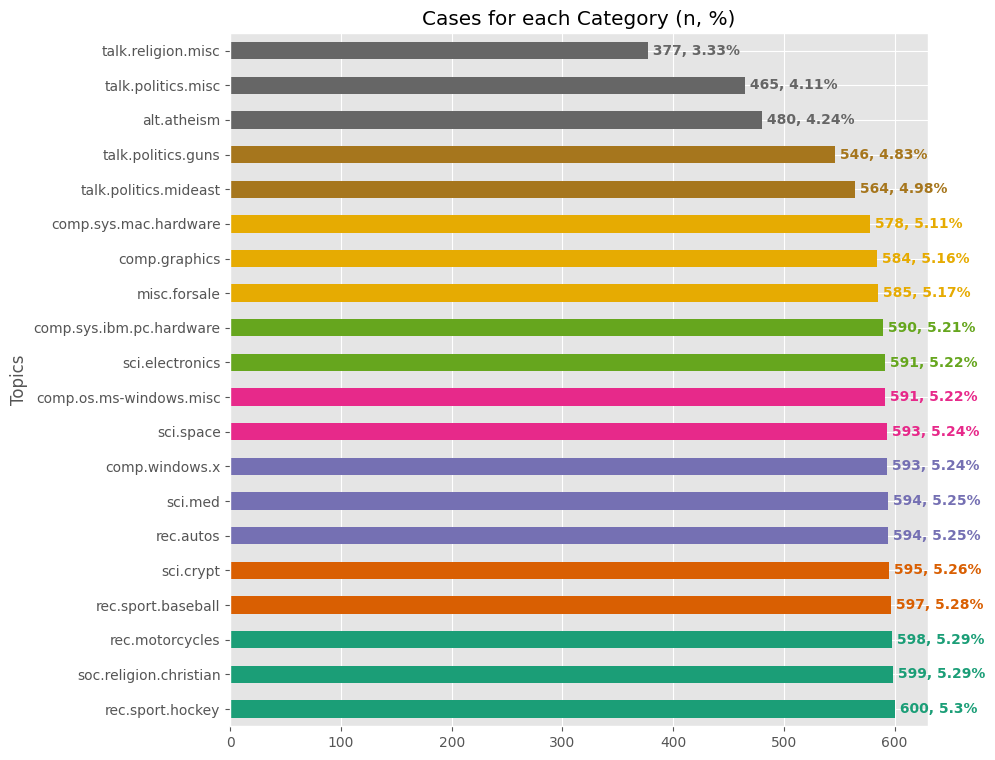

In [ ]:
num_classes = len(train["title"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

train['title'].value_counts().plot.barh(title="Cases for each Category (n, %)",
                                                 ylabel="Topics",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(train["title"].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/train.shape[0],2))+"%",
           color=c,
           va='center',
           fontweight='bold')

In [ ]:
x_train, x_test = train.text.values, test.text.values
y_train, y_test = tf.keras.utils.to_categorical(train.target.values, num_classes=num_classes),tf.keras.utils.to_categorical(test.target.values, num_classes=num_classes)

In [ ]:
# y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)
# x_train, x_test, y_train, y_test = train_test_split(df['Text'], y, test_size=0.25)

In [ ]:
train.groupby(['title','target']).size().reset_index()

,title,target,0
0,alt.atheism,0,480
1,comp.graphics,1,584
2,comp.os.ms-windows.misc,2,591
3,comp.sys.ibm.pc.hardware,3,590
4,comp.sys.mac.hardware,4,578
5,comp.windows.x,5,593
6,misc.forsale,6,585
7,rec.autos,7,594
8,rec.motorcycles,8,598
9,rec.sport.baseball,9,597


#### Apply BERT embedding and explore data

In [ ]:
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "The models are great"]
)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-6.13365956e-02, -4.06551242e-01,  3.43820572e-01,
        -2.78717875e-01,  3.70145589e-01, -1.67826489e-01,
        -2.89006889e-01, -1.55835104e+00, -5.41590512e-01,
        -9.78578329e-02, -5.96082032e-01, -7.06085861e-01,
        -2.17624441e-01, -7.03584969e-01, -8.74639034e-01,
        -2.43726805e-01,  3.28421474e-01,  8.86281505e-02,
         4.95931774e-01, -9.43830907e-01, -2.92386651e-01,
        -5.71699798e-01, -1.88589647e-01,  2.66202718e-01,
        -3.12623441e-01, -3.06769204e+00,  2.59565771e-01,
        -5.01978695e-01, -4.12489176e-01, -5.79225898e-01,
        -3.64644788e-02, -2.40692779e-01, -1.19100131e-01,
        -4.19667512e-01, -2.80515879e-01,  4.05802161e-01,
         3.57391685e-03,  4.74462003e-01,  2.53267586e-01,
         1.60581365e-01, -3.66707630e-02, -3.98249060e-01,
        -1.82141379e-01,  8.64678323e-01, -4.32331681e-01,
         1.36183277e-01,  4.67876881e-01,  1.54133081e-01,
      

In [ ]:
def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues",
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

In [ ]:
train.text[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

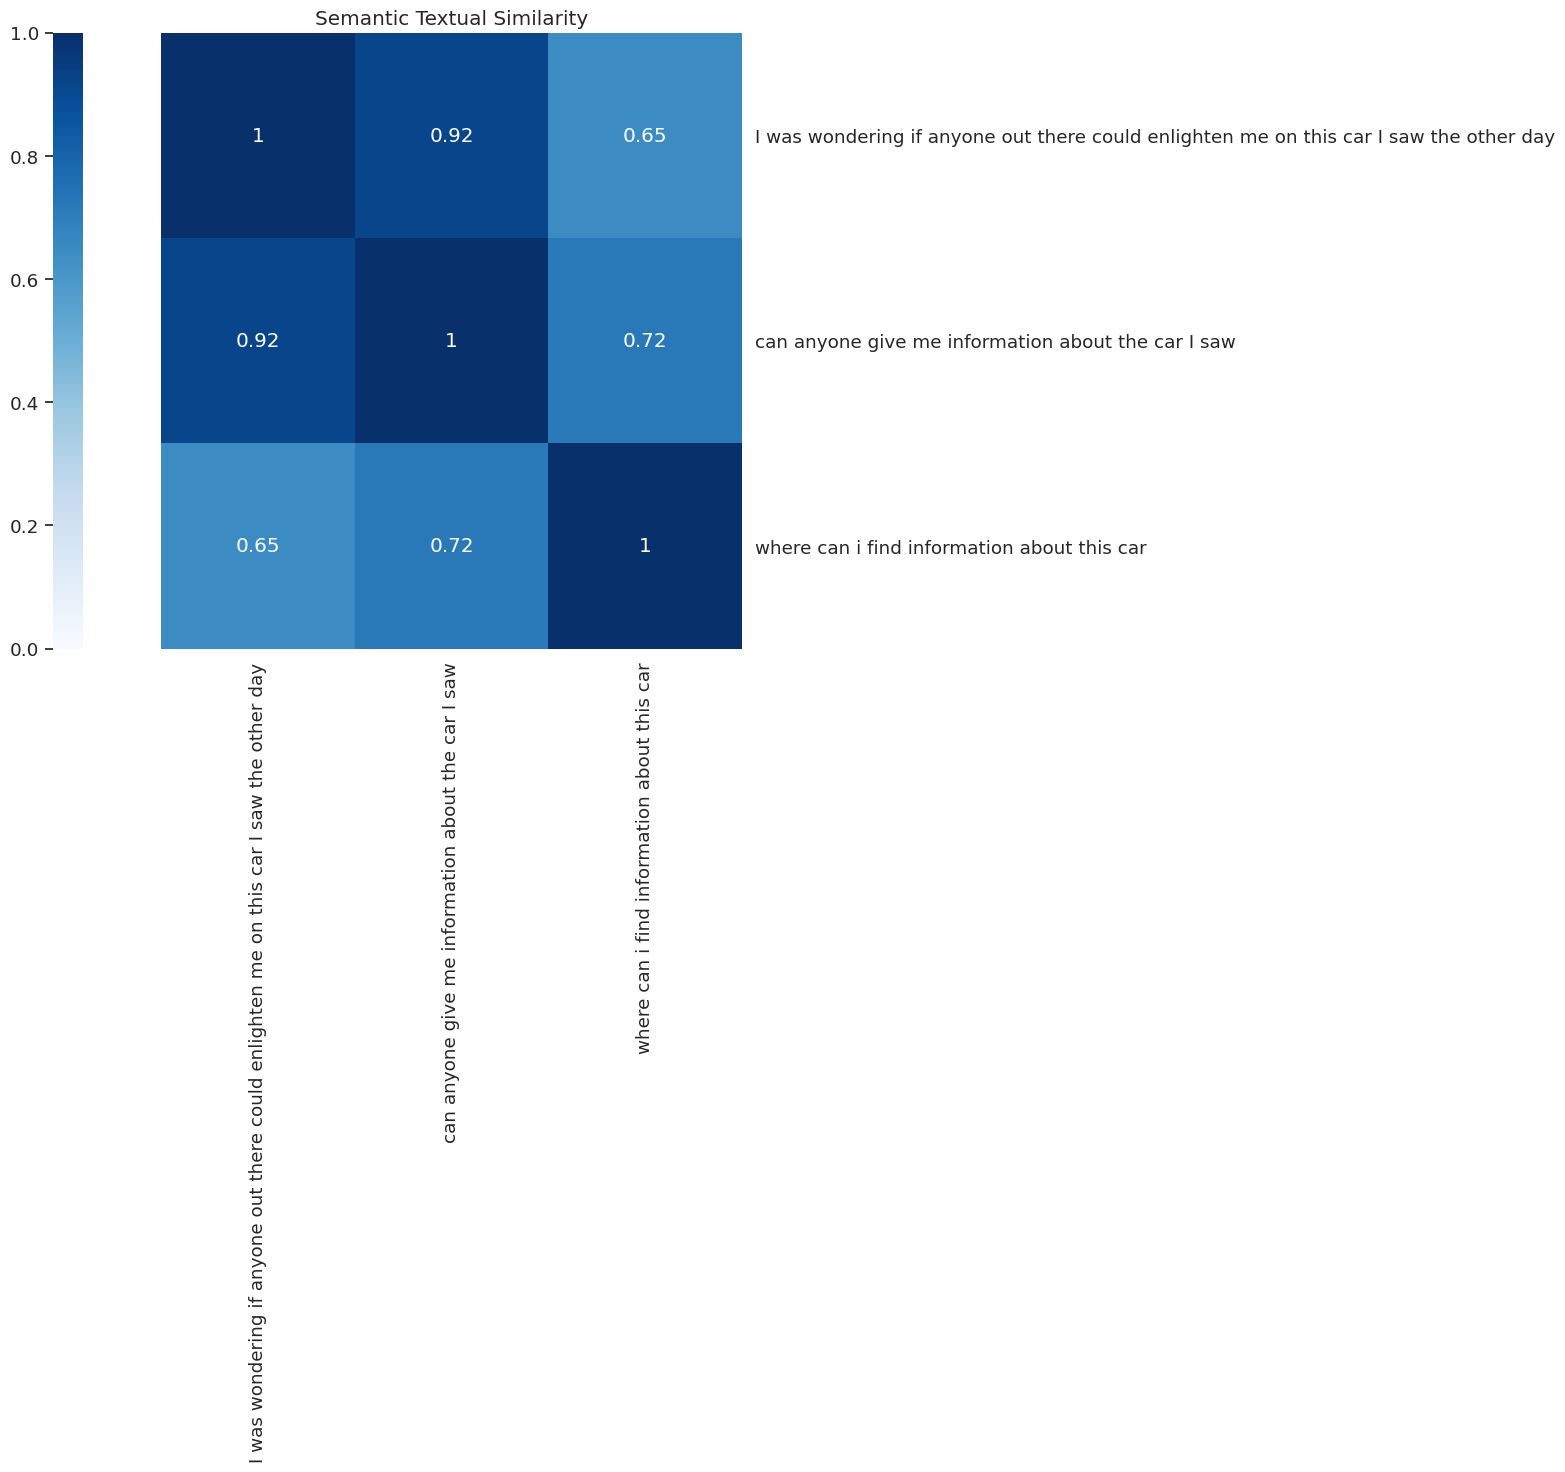

In [ ]:
sentences = ["I was wondering if anyone out there could enlighten me on this car I saw the other day",
           "can anyone give me information about the car I saw",
           "where can i find information about this car"]

plot_similarity(get_embeddings(sentences), sentences)

#### Create Model

In [ ]:
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 10

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train,
                      y_train,
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/10
354/354 [==============================] - 234s 603ms/step - loss: 1.9723 - accuracy: 0.4705 - balanced_recall: 0.0653 - balanced_precision: 0.1067 - balanced_f1_score: 0.0800 - val_loss: 1.4621 - val_accuracy: 0.6186 - val_balanced_recall: 0.0133 - val_balanced_precision: 0.0441 - val_balanced_f1_score: 0.0195
Epoch 2/10
354/354 [==============================] - 207s 586ms/step - loss: 1.2719 - accuracy: 0.6469 - balanced_recall: 0.2895 - balanced_precision: 0.4038 - balanced_f1_score: 0.3356 - val_loss: 1.2512 - val_accuracy: 0.6456 - val_balanced_recall: 0.0224 - val_balanced_precision: 0.0520 - val_balanced_f1_score: 0.0297
Epoch 3/10
354/354 [==============================] - 215s 608ms/step - loss: 1.1155 - accuracy: 0.6772 - balanced_recall: 0.3733 - balanced_precision: 0.4828 - balanced_f1_score: 0.4197 - val_loss: 1.1886 - val_accuracy: 0.6452 - val_balanced_recall: 0.0261 - val_balanced_precision: 0.0522 - val_balanced_f1_score: 0.0336
Epoch 4/10
354/354 [========

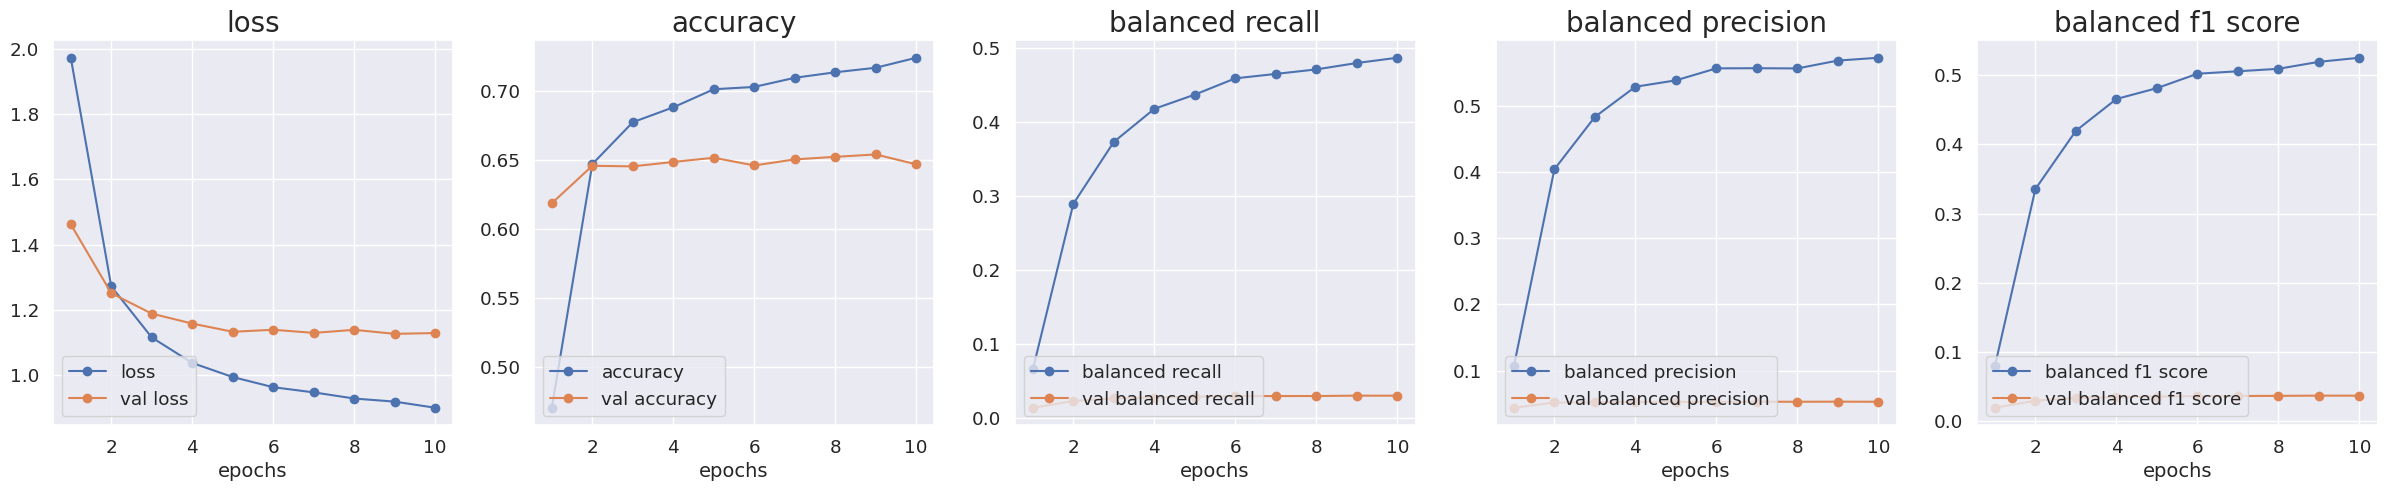

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

#### Score New Data

In [ ]:
def predict_class(docs):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(docs)]

predict_class(docs)

In [ ]:
# load blind set
test_set = pd.read_excel('/topics_rome_subset_test.xlsx')
test_set.head()

In [ ]:
y_pred = predict_class(test_set["Text"])
print(classification_report(test_set["Labels"], y_pred))

In [ ]:
model.save("/models/text_classifier_v1")

In [ ]:
from tensorflow import keras

# load model
new_model = keras.models.load_model("/models/text_classifier_v1")

# test predictions
[np.argmax(pred) for pred in new_model.predict(docs)]

Adapted from 'Multi-class Text Classification using BERT and TensorFlow' by Nicolo Cosimo Albanese'

Published in Towards Data Science,Jan 19, 2022